# EDA for Natural Language Processing

- 06/15/21
- Phase 4 Project Office Hours

## Classifying Coronavirus-Related Tweets Sentiment

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>

<font size=3rem>
    
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
</font>
___

# INTRODUCTION

>- The Covid-19 pandemic has been an extreme moment in human history, in which the basic aspects of every day have been turned into complicated and risky endeavors. 
    - Understandably, the pandemic has generated a lot of strong feelings in individuals. 
    - These feelings can take on various forms: from frustration and anger to sadness and despair. 
    - Additionally, for many millen ials and Gen-Xers, the pandemic has actually been a postiive force in reducing social pressures.
    
    
> - For this analysis, we wanted to explore the nature of various sentiments related to Covid-19. Using covid-realated tweets from Kaggle, we will create a predictive model to predict the sentiment from the text. We will use these supervised learning models and additonal EDA to better understand the underlying reasons/motivations/issues for the various sentiments expressed. 

- Dataset from Kaggle:
    - https://www.kaggle.com/datatattle/covid-19-nlp-text-classification
- We will be using the `train.csv` dataset, which has been renamed to `cornavirus_tweets.csv.gz`

# OBTAIN

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
import string
from wordcloud import WordCloud



from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/raw/master/Phase_4/topic_42_tuning_neural_networks/data/cornavirus_tweets.csv.gz",
                 encoding='latin-1',parse_dates=['TweetAt'])
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41154,44951,89903,"Wellington City, New Zealand",2020-04-14,Airline pilots offering to stock supermarket s...,Neutral
41155,44952,89904,NaN,2020-04-14,Response to complaint not provided citing COVI...,Extremely Negative
41156,44953,89905,NaN,2020-04-14,You know itÃÂs getting tough when @KameronWi...,Positive
41157,44954,89906,NaN,2020-04-14,Is it wrong that the smell of hand sanitizer i...,Neutral


In [4]:
## SAMPLING FOR SG

df = df.sample(n=10000)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 5002 to 13058
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       10000 non-null  object        
 1   ScreenName     10000 non-null  object        
 2   Location       7913 non-null   object        
 3   TweetAt        10000 non-null  datetime64[ns]
 4   OriginalTweet  10000 non-null  object        
 5   Sentiment      10000 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 546.9+ KB


## Data

- Columns of interest are:
    - For NLP classification:
        - Sentiment
        - OriginalTweet,
    - For EDA:
        - Sentiment
        - Location
        - TweetAt
        

# SCRUB

In [6]:
## Check for nulls
def null_check(df):
    """Returns a dataframe of null value counts andd %'s'"""
    nulls = df.isna().sum()
    return pd.DataFrame({'nulls':nulls,
                  '%null':nulls/len(df)*100}).round(2)
null_check(df)

,nulls,%null
UserName,0,0.00
ScreenName,0,0.00
Location,2087,20.87
TweetAt,0,0.00
OriginalTweet,0,0.00
Sentiment,0,0.00


- Drop nulls from subset=['OriginalTweet','Sentiment']
- Fill Nulls:
    - Location: "Unknown"

In [7]:
## deal with nulls and check
df['Location'].fillna('Unknown',inplace=True)
df.dropna(subset=['TweetAt','OriginalTweet','Sentiment'],inplace=True)

null_check(df)

,nulls,%null
UserName,0,0.0
ScreenName,0,0.0
Location,0,0.0
TweetAt,0,0.0
OriginalTweet,0,0.0
Sentiment,0,0.0


# EXPLORE

### Resources
- https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d

In [8]:
## How many unique users?
df['UserName'].nunique()

10000

In [9]:
## Are any users represented more than once?
user_counts = df["UserName"].value_counts()
user_counts[user_counts >1]

Series([], Name: UserName, dtype: int64)

## Exploring Sentiment

In [10]:
df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Neutral', 'Extremely Positive',
       'Negative'], dtype=object)

In [11]:
## Make list of sentiments for ordering plots 
sentiment_order = ['Extremely Negative', 'Negative','Neutral',
                   'Positive','Extremely Positive']

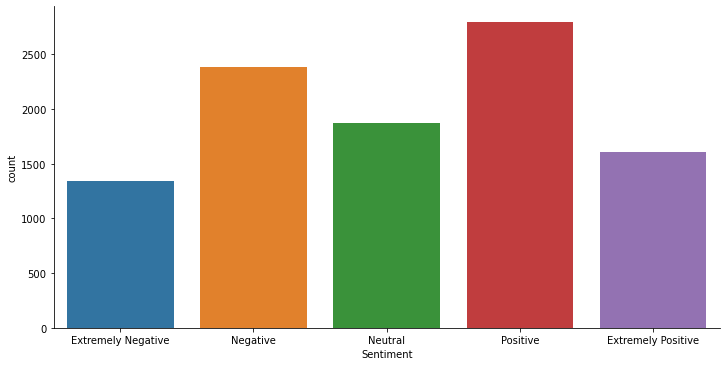

In [12]:
## Overall sentiment distribution
sns.catplot(data=df,x='Sentiment',kind='count',order=sentiment_order,aspect=2)

In [13]:
df['Sentiment'].value_counts(1)

Positive              0.2799
Negative              0.2383
Neutral               0.1870
Extremely Positive    0.1610
Extremely Negative    0.1338
Name: Sentiment, dtype: float64

>- The dataset has 5 sentiment ratings ranging from Extremely Negative to Extremely Positive. 
    - The classes are approximately balanced, but The Extreme sentiments and Neutral sentiments have fewer obserations

### Making a SimpleSentiment column as a 3-class column

In [14]:
simple_sentiment_mapper = {'Extremely Negative':"Negative",
                            'Negative':'Negative',
                            'Neutral':'Neutral',
                            'Positive':'Positive',
                            'Extremely Positive':'Positive'}
df['SimpleSentiment'] = df["Sentiment"].replace(simple_sentiment_mapper)
df["SimpleSentiment"].value_counts(1,dropna=False)

Positive    0.4409
Negative    0.3721
Neutral     0.1870
Name: SimpleSentiment, dtype: float64

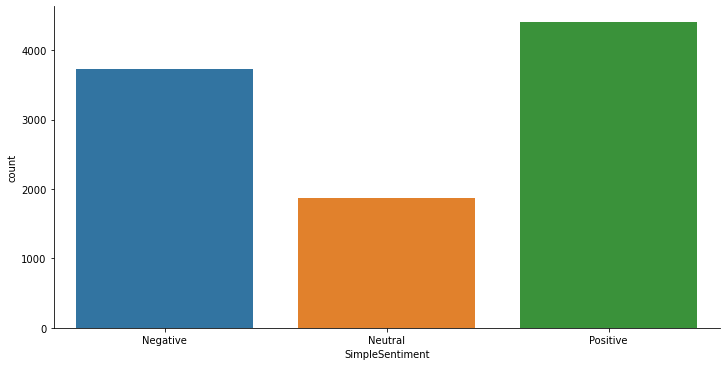

In [15]:
## Overall sentiment distribution
sns.catplot(data=df,x='SimpleSentiment',kind='count',
            order=['Negative','Neutral','Positive'],aspect=2)

> The simpler 3 class version of Sentiment creates a class imbalance issue with neutral tweets having the fewest observations.

## Exploring Location

In [16]:
## How many locations?
location_counts = df['Location'].value_counts()
location_counts.head(40)

Unknown                    2087
United States               146
London, England             136
London                      135
New York, NY                 96
Washington, DC               93
United Kingdom               79
Los Angeles, CA              73
India                        70
Australia                    65
USA                          62
UK                           50
Canada                       46
Global                       43
England, United Kingdom      42
Atlanta, GA                  42
Toronto, Ontario             39
San Francisco, CA            38
Boston, MA                   37
California, USA              36
Chicago, IL                  34
Toronto                      33
London, UK                   33
New York, USA                31
Seattle, WA                  27
Lagos, Nigeria               26
Austin, TX                   23
Sydney, New South Wales      23
New York                     23
Mumbai, India                23
Mumbai                       23
NYC     

> - Will analyze locations with more than 100 tweets.

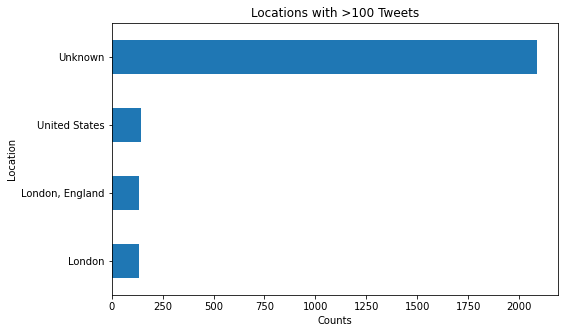

In [17]:
## Visualize locations with >100 tweets
frequent_locations = location_counts[(location_counts>100)&(location_counts<6000)]
ax = frequent_locations.sort_values().plot(kind='barh',figsize=(8,5))
ax.set(xlabel='Counts',ylabel='Location',title='Locations with >100 Tweets');

In [18]:
## Saving just most frequent locations
df_freq_location = df[df['Location'].isin(frequent_locations.index)]
df_freq_location

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,SimpleSentiment
36843,40641,85593,Unknown,2020-10-04,Finally stocked up after being down to our las...,Positive,Positive
25359,29158,74110,Unknown,2020-03-31,If someone is willing to supply testing kits a...,Extremely Positive,Positive
37234,41032,85984,Unknown,2020-10-04,shibley And a point worthy of note given no on...,Positive,Positive
10757,14556,59508,Unknown,2020-03-20,When people who said 'you don't want to end up...,Positive,Positive
11611,15410,60362,London,2020-03-20,Is panic buying irrational?\r\r\n\r\r\nMicroec...,Extremely Negative,Negative
...,...,...,...,...,...,...,...
149,3948,48900,London,2020-03-16,First shops to make this effort could really w...,Extremely Positive,Positive
5227,9026,53978,Unknown,2020-03-18,EveryoneÃÂs been panic buying bread and food...,Negative,Negative
34273,38071,83023,Unknown,2020-08-04,Online grocery delivery orders surge as millio...,Neutral,Neutral
37546,41344,86296,Unknown,2020-10-04,"ÃÂSo when you buy at our market, youÃÂre s...",Positive,Positive


### Sentiment Word Usage

In [47]:
## save a dictionary with each sentiment's df saved under the sentiment type
sent_dict = {}
for sentiment in df["SimpleSentiment"].unique():
    
    sent_dict[sentiment] = df[ df['Sentiment']==sentiment]
    
sent_dict.keys()

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['Positive', 'Negative', 'Neutral'])

In [48]:
tokenizer = TweetTokenizer(preserve_case=False)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
## save stopwords
stopwords_list = nltk.corpus.stopwords.words('english')
stopwords_list.extend(string.punctuation)
stopwords_list.extend(['http','https','co'])

covid_stopwords = [*stopwords_list, 'coronavirus','covid',
                  'covid19','covid_19','covid2019',"#coronavirus",
                  "#covid_19",'']

In [49]:
def prep_wordcloud_corpus(df,stopwords_list,text_col='OriginalTweet'):
    ## save neg_corpus and remove stopwords
    corpus = tokenizer.tokenize(' '.join(df[text_col]))
    corpus = [w.encode('ascii','ignore').decode() for w in corpus if w not in stopwords_list]
    return corpus


corpus_dict = {sentiment:prep_wordcloud_corpus(sents,covid_stopwords) for sentiment,sents \
                                                       in sent_dict.items()}
# neg_corpus = prep_wordcloud_corpus(neg_sents)
# pos_corpus = prep_wordcloud_corpus(pos_sents)
# neut_corpus = prep_wordcloud_corpus(neu_sents)
corpus_dict['Negative'][:5]

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['lowest', 'prices', '#quatchicam', '#socialdistancing', '#coronacrisis']

In [50]:
## MOST FREQUENT NEGATIVE TWEET WORDS
neg_freq = nltk.FreqDist(corpus_dict['Negative'])


neg_freq_df = pd.DataFrame(neg_freq.most_common(25),columns=['Word','Frequency'])
neg_freq_df

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Word,Frequency
0,,2447
1,19,745
2,prices,586
3,food,480
4,supermarket,399
5,people,381
6,store,360
7,grocery,325
8,#covid19,269
9,demand,228


/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Text(0.5, 1.0, '25 Most Common Words in Negative Tweets')]

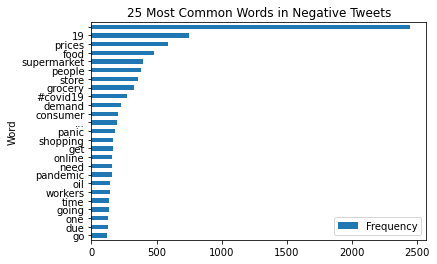

In [51]:
ax = neg_freq_df.set_index('Word').sort_values('Frequency').plot(kind='barh')
ax.set(title="25 Most Common Words in Negative Tweets")

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Text(0.5, 1.0, '25 Most Common Words in Positive Tweets')]

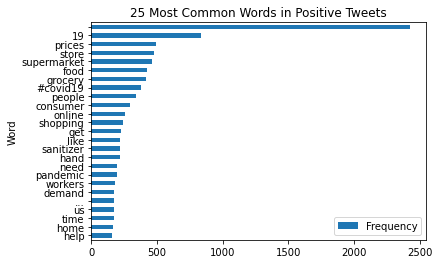

In [52]:
## MOST FREQUENT NEGATIVE TWEET WORDS

pos_freq = nltk.FreqDist(corpus_dict['Positive'])
pos_freq_df = pd.DataFrame(pos_freq.most_common(25),columns=['Word','Frequency'])
ax = pos_freq_df.set_index('Word').sort_values('Frequency').plot(kind='barh')
ax.set(title="25 Most Common Words in Positive Tweets")



### Comparing All 3 Sentiments Word Frequencies via WordClouds

In [56]:

### Specify params for all 3 word clouds
cloud_stopwords = [*stopwords_list, 'coronavirus','covid',
                  'covid19','covid_19','covid2019']

cloud_kws = dict(collocations=True,normalize_plurals=False,
                          stopwords=cloud_stopwords,
                          width=1200,min_word_length=2,
                          height=800,min_font_size=10)


## Tweaking final params aand generating clouds
wordcloud_dict = {}

wordcloud_dict['Negative']  = WordCloud(**cloud_kws,
                                        colormap='Reds'
                                       ).generate(' '.join(corpus_dict['Negative']))

wordcloud_dict['Neutral']  = WordCloud(**cloud_kws,
                                        colormap='Greys'
                                       ).generate(' '.join(corpus_dict['Neutral']))

wordcloud_dict['Positive']  = WordCloud(**cloud_kws,
                                        colormap='Greens'
                                       ).generate(' '.join(corpus_dict['Positive']))


/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


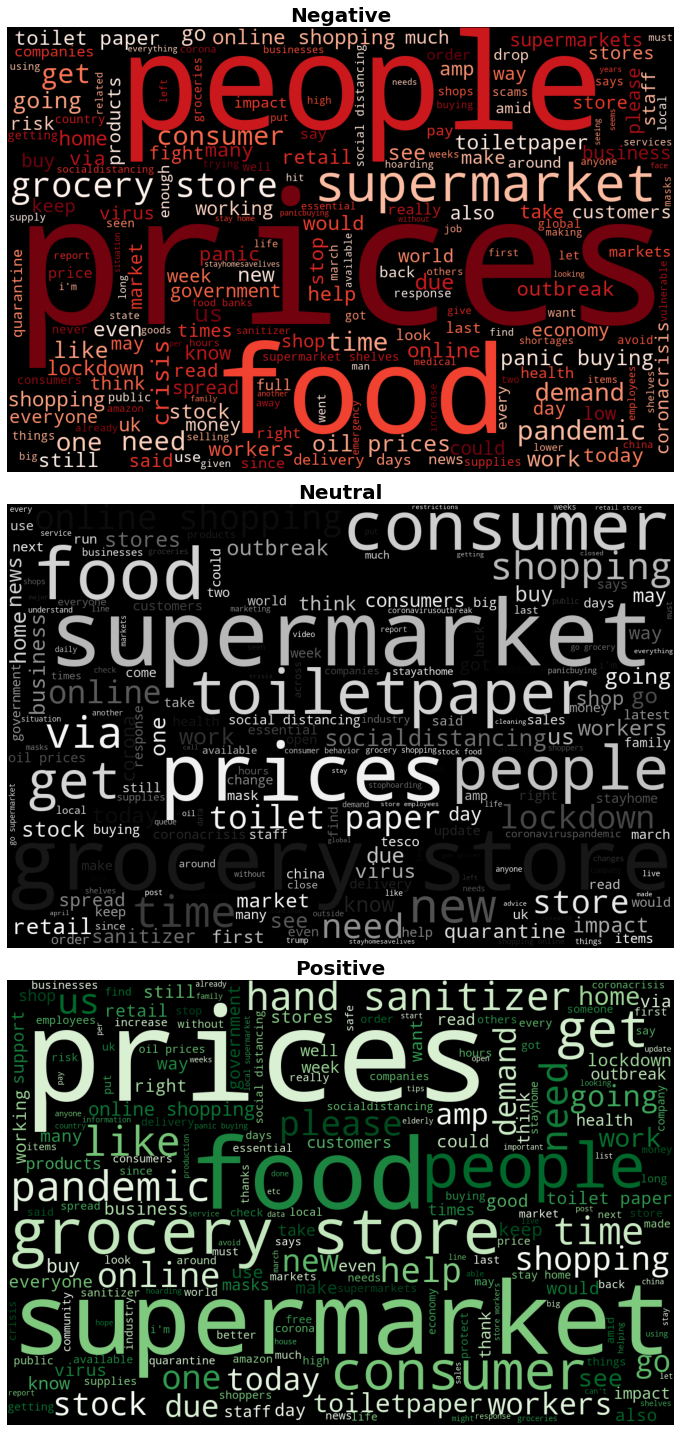

In [57]:
## Plot all 3 classes
fig, ax = plt.subplots(nrows=len(wordcloud_dict.keys()), figsize=(16,20))

title_font = {'fontweight':'bold','fontsize':20}
# cmap_list = ['Reds','Greens','Greys']

i=0
for sentiment, cloud in wordcloud_dict.items():
    ax[i].imshow(cloud)
    ax[i].set_title(sentiment,fontdict=title_font)
    ax[i].axis('off')
    i+=1
    
plt.tight_layout()

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


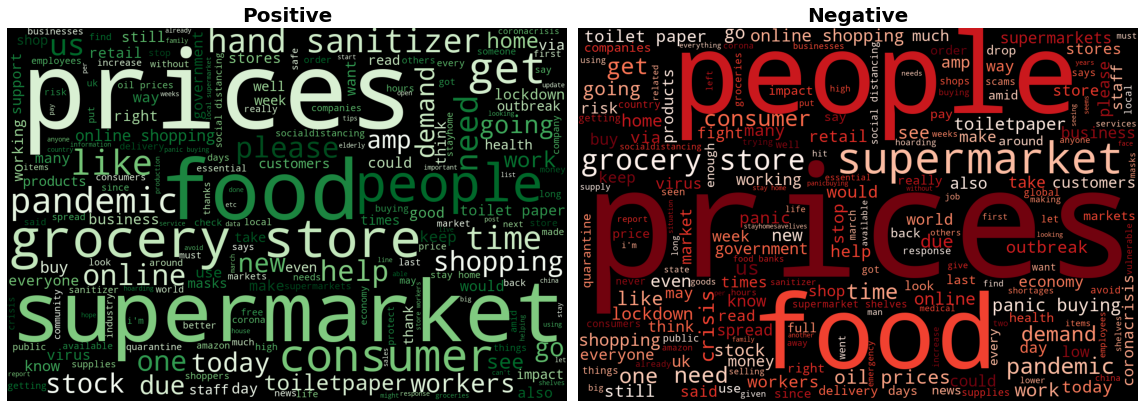

In [58]:
## Plot pos and neg side by side
fig, ax = plt.subplots(ncols=2, figsize=(16,20))

title_font = {'fontweight':'bold','fontsize':20}

sentiment = 'Positive'
ax[0].imshow(wordcloud_dict[sentiment])
ax[0].set_title(sentiment,fontdict=title_font)
ax[0].axis('off')

sentiment = 'Negative'

ax[1].imshow(wordcloud_dict[sentiment])
ax[1].set_title(sentiment,fontdict=title_font)
ax[1].axis('off')
plt.tight_layout()

# MODEL

## Make X,y + train_test_spit

In [59]:
## Make a dict mapper for target
target_map = dict(zip(sentiment_order,range(len(sentiment_order)+1)))
target_map

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Extremely Negative': 0,
 'Negative': 1,
 'Neutral': 2,
 'Positive': 3,
 'Extremely Positive': 4}

In [60]:
## mapper for Simpler 3-class target
target_map_3class = {'Extremely Negative':0, 
                     'Negative':0,
                     'Neutral':1, 
                     'Positive':2,
                     'Extremely Positive':2}
target_map_3class

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Extremely Negative': 0,
 'Negative': 0,
 'Neutral': 1,
 'Positive': 2,
 'Extremely Positive': 2}

In [61]:
## making numeric target col
df['target']=df['Sentiment'].map(target_map)
df['target'].value_counts(dropna=False,normalize=True)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3    0.2799
1    0.2383
2    0.1870
4    0.1610
0    0.1338
Name: target, dtype: float64

In [62]:
df['target_3class']=df['Sentiment'].map(target_map_3class)
df['target_3class'].value_counts(dropna=False,normalize=True)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2    0.4409
0    0.3721
1    0.1870
Name: target_3class, dtype: float64

In [63]:
X = df['OriginalTweet'].copy()
y = df['target_3class'].copy()#.map(target_map)
y.value_counts(1)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2    0.4409
0    0.3721
1    0.1870
Name: target_3class, dtype: float64

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,
                                                    random_state=321)


/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
from sklearn import set_config
set_config(display='diagram')

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
## From tjhe lessons
from nltk import regexp_tokenize
pattern = r"([a-zA-Z]+(?:'[a-z]+)?)"
regexp_tokenize("I can't wait for summer. Ain't it grand",pattern)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['I', "can't", 'wait', 'for', 'summer', "Ain't", 'it', 'grand']

In [75]:
tokenizer = TweetTokenizer(preserve_case=False,strip_handles=False)
tokenizer.tokenize("I can't wait for summer. Ain't it grand")

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['i', "can't", 'wait', 'for', 'summer', '.', "ain't", 'it', 'grand']

In [105]:
# abbrev_dict= {' OT ':'overtime',
#              'HR':'human resources'}

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:

df['TweetsNoApos'] = df['OriginalTweet'].map(lambda x: x.replace("'",''))
df

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,SimpleSentiment,target,target_3class,TweetsNoApos
5002,8801,53753,"Burlington, VT",2020-03-18,Why consider $corn allocations? Have you seen ...,Positive,Positive,3,2,Why consider $corn allocations? Have you seen ...
8296,12095,57047,Ho Chi Minh City. Vietnam,2020-03-19,#PetroVietnam said on Wednesday it is consider...,Extremely Negative,Negative,0,0,#PetroVietnam said on Wednesday it is consider...
10123,13922,58874,Australia,2020-03-20,Planning a after the ends in southeast Need a ...,Neutral,Neutral,2,1,Planning a after the ends in southeast Need a ...
10832,14631,59583,europe,2020-03-20,With all the panic buying and hoarding going o...,Positive,Positive,3,2,With all the panic buying and hoarding going o...
30628,34427,79379,"Miami, FL",2020-06-04,@DeniseC66303455 @DailyCaller With oil prices ...,Extremely Negative,Negative,0,0,@DeniseC66303455 @DailyCaller With oil prices ...
...,...,...,...,...,...,...,...,...,...,...
37546,41344,86296,Unknown,2020-10-04,"ÃÂSo when you buy at our market, youÃÂre s...",Positive,Positive,3,2,"ÃÂSo when you buy at our market, youÃÂre s..."
35867,39665,84617,"Mississippi, USA",2020-09-04,MDOC Horhn MS65 50 MS brown MISSISSIPPI PRISON...,Extremely Negative,Negative,0,0,MDOC Horhn MS65 50 MS brown MISSISSIPPI PRISON...
2001,5800,50752,Convenience Stores Worldwide,2020-03-17,Single-use products now in big demand as the p...,Positive,Positive,3,2,Single-use products now in big demand as the p...
31742,35541,80493,NEW DELHI,2020-07-04,@drharshvardhan @PMOIndia @narendramodi @aajta...,Positive,Positive,3,2,@drharshvardhan @PMOIndia @narendramodi @aajta...


In [81]:
df[df['OriginalTweet'].str.contains("'")]

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,SimpleSentiment,target,target_3class,TweetsNoApos
15279,19078,64030,"Arizona, USA",2020-03-22,I've received many emails from business in reg...,Neutral,Neutral,2,1,Ive received many emails from business in rega...
10757,14556,59508,Unknown,2020-03-20,When people who said 'you don't want to end up...,Positive,Positive,3,2,When people who said you dont want to end up s...
29511,33310,78262,"London, England",2020-05-04,It's very sad that bus drivers are on the fron...,Negative,Negative,1,0,Its very sad that bus drivers are on the front...
4941,8740,53692,"Biloxi, Mississippi",2020-03-18,@HankAllenWX Not here in #WestBiloxi where the...,Negative,Negative,1,0,@HankAllenWX Not here in #WestBiloxi where the...
14094,17893,62845,United States,2020-03-21,With myself being in semi-self-quarantine (I s...,Positive,Positive,3,2,With myself being in semi-self-quarantine (I s...
...,...,...,...,...,...,...,...,...,...,...
5447,9246,54198,California,2020-03-19,"Social Distancing doesn't have to be a drag, t...",Negative,Negative,1,0,"Social Distancing doesnt have to be a drag, ta..."
7314,11113,56065,#thesix,2020-03-19,HUGS to the mom &amp; pop shop on College Stre...,Extremely Positive,Positive,4,2,HUGS to the mom &amp; pop shop on College Stre...
25979,29778,74730,"Morrisville, NC",2020-01-04,We've got newly updated info about online shop...,Extremely Positive,Positive,4,2,Weve got newly updated info about online shopp...
21021,24820,69772,"Toronto, Ontario",2020-03-25,WE ARE OPEN - More hand sanitizer and supplies...,Extremely Positive,Positive,4,2,WE ARE OPEN - More hand sanitizer and supplies...


In [83]:
# "can't" in stopwords_lista
'!' in stopwords_list
stopwords_list.remove('!')

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
'!' in stopwords_list

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False

In [95]:
## set up text preprocessing pipeline
tokenizer = TweetTokenizer(preserve_case=False,strip_handles=False)

text_pipe = Pipeline([
    ('vectorizer',CountVectorizer(strip_accents='unicode',
                                  tokenizer=tokenizer.tokenize,
#                                   token_pattern= r"([a-zA-Z]+(?:'[a-z]+)?)",
                          
                                 stop_words=stopwords_list)),
    ('tfidf',TfidfTransformer()) 
])
text_pipe

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode',
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7f92ce744700>>)),
                ('tfidf', TfidfTransformer())])

In [96]:
X_train_vec = text_pipe.fit_transform(X_train)
X_test_vec = text_pipe.transform(X_test)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
resulting_words = text_pipe['vectorizer'].get_feature_names()
resulting_words[:10]

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['aa',
 'aaa',
 'aacxqg',
 'aaefyolyb',
 'aagzjfou',
 'aajtak',
 'aaltouniversity',
 'aang',
 'aaron',
 'aaronchown']

In [73]:
"can't" in resulting_words

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

## TSNE 

In [38]:
from sklearn.manifold import TSNE
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

In [39]:
## TSNE For Visualizing High Dimensional Data
t_sne_object_3d = TSNE(n_components=3,n_iter=500)
transformed_data_3d = t_sne_object_3d.fit_transform(X_train_vec)
transformed_data_3d

array([[-22.931969 ,   0.4693043, -16.56662  ],
       [-11.716256 ,  12.570934 ,  -3.224143 ],
       [-18.995094 ,  11.667617 , -16.317331 ],
       ...,
       [ -2.6166272, -15.188698 , -10.352359 ],
       [ -0.6885751,  28.190844 ,   8.547425 ],
       [ 17.503862 ,  13.014337 ,   3.449941 ]], dtype=float32)

In [40]:
## Saving each sentiment as its own matrix for plotting
neg_tsne = transformed_data_3d[y_train==0]
neut_tsne = transformed_data_3d[y_train==1]
pos_tsne = transformed_data_3d[y_train==2]

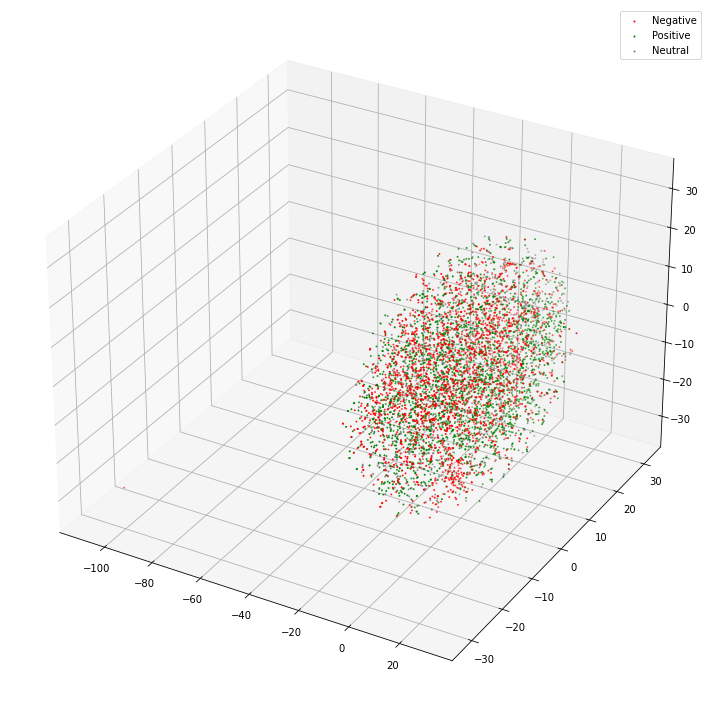

In [41]:
## Visualize TSNE
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(neg_tsne[:,0],neg_tsne[:,1],
           neg_tsne[:,2],s=1, c='red',label='Negative')

ax.scatter(pos_tsne[:,0],pos_tsne[:,1],
           pos_tsne[:,2],s=1,c='green',label='Positive')

ax.scatter(neut_tsne[:,0],neut_tsne[:,1],
           neut_tsne[:,2],s=1,c='gray',label='Neutral')


ax.legend()
# ax.view_init(30, 10)


fig.tight_layout()

### Latent Dirichilet Allocation

- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
- https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d

In [42]:
from sklearn.decomposition import LatentDirichletAllocation 
lda = LatentDirichletAllocation(n_components=5,verbose=1,random_state=0)
lda.fit(X_train_vec)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(n_components=5, random_state=0, verbose=1)

### PyLDAvis

- https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know
- https://github.com/bmabey/pyLDAvis
- https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

In [43]:
# !pip install pyldavis

In [44]:
import pyLDAvis
import pyLDAvis.sklearn as lda_sk
pyLDAvis.enable_notebook()

In [45]:
lda_sk.prepare(lda,X_train_vec,text_pipe['vectorizer'])

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.039906 -0.014719       1        1  26.859720
2     -0.003627  0.031109       2        1  20.881346
3      0.011776  0.010319       3        1  18.569888
4      0.007678 -0.002870       4        1  17.899160
0      0.024079 -0.023839       5        1  15.789886, topic_info=              Term       Freq      Total Category  logprob  loglift
23238      workers  29.000000  29.000000  Default  30.0000  30.0000
18398        paper  17.000000  17.000000  Default  29.0000  29.0000
22097       toilet  17.000000  17.000000  Default  28.0000  28.0000
23405              79.000000  79.000000  Default  27.0000  27.0000
23408              55.000000  55.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
18555       people   4.260604  45.700510   Topic5  -6.8064  -0.5269
8848      consumer   3.818871  36.406972   Topic5  -6.9159  -0.4090
8973   coronavirus   3.307246  24.407332   Topic5  -7.0597  -0.1530
18368     pandemic   3.421766  27.946755   Topic5  -7.0257  -0.2543
11973         home   3.162738  24.143613   Topic5  -7.1044  -0.1868

[416 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
373        3  1.068719  #boycottsportsdirect
422        5  0.778079            #bushcraft
478        2  0.688495           #capitalism
762        1  0.279913          #coronavirus
762        2  0.198272          #coronavirus
...      ...       ...                   ...
23408      3  0.108843                     
23408      4  0.163264                     
23408      5  0.145123                     
23411      1  0.801858                     
23411      5  0.200465                     

[655 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 5, 1])

In [46]:
raise Exception('stop here for study group')

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Exception: stop here for study group

# Models

## Model Evaluation Functions

In [91]:
def evaluate_classification(model, X_test_tf,y_test,cmap='Greens',
                            normalize='true',classes=None,figsize=(10,4),
                            X_train = None, y_train = None,):
    """Evaluates a scikit-learn binary classification model.

    Args:
        model (classifier): any sklearn classification model.
        X_test_tf (Frame or Array): X data
        y_test (Series or Array): y data
        cmap (str, optional): Colormap for confusion matrix. Defaults to 'Greens'.
        normalize (str, optional): normalize argument for plot_confusion_matrix. 
                                    Defaults to 'true'.
        classes (list, optional): List of class names for display. Defaults to None.
        figsize (tuple, optional): figure size Defaults to (8,4).
        
        X_train (Frame or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
        y_train (Series or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
    """
    
    ## Get Predictions and Classification Report
    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    
    ## Plot Confusion Matrid and roc curve
    fig,ax = plt.subplots(ncols=2, figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    
    ## if roc curve erorrs, delete second ax
    try:
        curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
        curve.ax_.grid()
        curve.ax_.plot([0,1],[0,1],ls=':')
        fig.tight_layout()
    except:
        fig.delaxes(ax[1])
    plt.show()
    
    ## Add comparing Scores if X_train and y_train provided.
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")
        
        

    
def plot_importance(tree, X_train_df, top_n=20,figsize=(10,10)):
    
    df_importance = pd.Series(tree.feature_importances_,
                              index=X_train_df.columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize,title='Feature Importances',
    ylabel='Feature',)
    return df_importance



/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Modeling Logistics

1. Use the same variable name for each of the types of models to fit to save memory. 
2. After evaluating, save the model with joblib as f"last_{model type}.joblib"

3. Load up the models after training if want to get insights or compare.

In [107]:
import os,joblib
save_path = "./models/"
os.makedirs(save_path, exist_ok=True)
sorted(os.listdir(save_path))

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[]

## Model 1: LogisticRegression

In [108]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn import metrics

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Vanilla LogReg, no regularization

In [109]:
y_train.value_counts(1).sort_index()

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    0.374667
1    0.185667
2    0.439667
Name: target_3class, dtype: float64

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='target_3class', ylabel='count'>

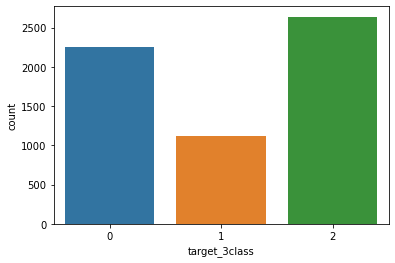

In [110]:
sns.countplot(y_train)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1473
           1       0.52      0.48      0.50       756
           2       0.74      0.75      0.75      1771

    accuracy                           0.69      4000
   macro avg       0.66      0.65      0.65      4000
weighted avg       0.69      0.69      0.69      4000



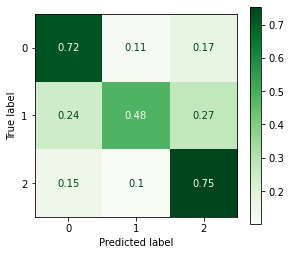

Training Score = 1.00
Test Score = 0.69


['./models/log_reg_ce12.joblib']

In [111]:
## Log reg- not using classweight
clf = LogisticRegression(C=1e12, max_iter=300)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec, y_test,X_train = X_train_vec,y_train=y_train)

joblib.dump(clf, f"{save_path}log_reg_ce12.joblib")

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.69      0.74      0.71      1473
           1       0.55      0.41      0.47       756
           2       0.73      0.76      0.75      1771

    accuracy                           0.69      4000
   macro avg       0.66      0.64      0.64      4000
weighted avg       0.68      0.69      0.68      4000



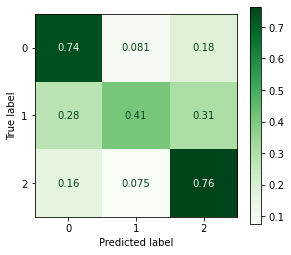

Training Score = 1.00
Test Score = 0.69


['./models/log_reg_ce12.joblib']

In [112]:
clf = LogisticRegression(C=1e12,class_weight='balanced', max_iter=300)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec, y_test,X_train = X_train_vec,y_train=y_train)

joblib.dump(clf, f"{save_path}log_reg_ce12.joblib")

### GridSearch for C

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.3s finished


              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1473
           1       0.52      0.55      0.53       756
           2       0.76      0.73      0.74      1771

    accuracy                           0.69      4000
   macro avg       0.66      0.66      0.66      4000
weighted avg       0.69      0.69      0.69      4000



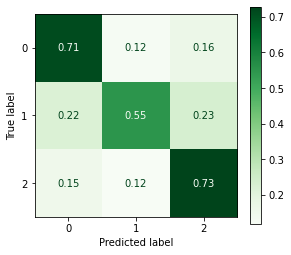

Training Score = 0.99
Test Score = 0.66
[2.7825594 2.7825594 2.7825594]


['./models/log_reg_cv.joblib']

In [114]:
clf = LogisticRegressionCV(class_weight='balanced',max_iter=300,cv=3,
                           scoring='recall_macro',n_jobs=-1,verbose=2)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)

print(clf.C_)
joblib.dump(clf, f"{save_path}log_reg_cv.joblib")

In [ ]:
best_C = 2.7825594
clf = LogisticRegression(C=best_C,class_weight='balanced', max_iter=300)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)
joblib.dump(clf,f"{save_path}log_reg_best_C.joblib")

### LogReg Full GridSearch

In [ ]:
## logreg gridsearch

clf = LogisticRegression(class_weight='balanced',solver='saga')

params = {'C':[1.0,3,10],
          'penalty':['elasticnet','l2','l1']
         }

gridsearch = GridSearchCV(clf,params,cv=3, scoring='recall_macro',
                          verbose=True, n_jobs=-1)

gridsearch.fit(X_train_vec,y_train)
print(gridsearch.best_params_)

evaluate_classification(gridsearch.best_estimator_, X_test_vec,y_test,
                        X_train = X_train_vec,y_train=y_train)

joblib.dump(gridsearch.best_estimator_,f"{save_path}gridsearch_log_reg.joblib")

### LogReg+Text Pipe GridSearch

In [86]:
## set up text preprocessing pipeline
tokenizer = TweetTokenizer(preserve_case=False,strip_handles=False)
text_pipe_grid = Pipeline([
    ('vectorizer',CountVectorizer(strip_accents='unicode',
                                  tokenizer=tokenizer.tokenize,
                                 stop_words=None)),#=stopwords_list)),
    ('tfidf',TfidfTransformer()) 
])
    
    
full_pipe = Pipeline([
    ('text',text_pipe_grid),
    ('clf',LogisticRegression(class_weight='balanced',solver='saga'))
])

full_pipe

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pipeline(steps=[('text',
                 Pipeline(steps=[('vectorizer',
                                  CountVectorizer(strip_accents='unicode',
                                                  tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7f92ce0474f0>>)),
                                 ('tfidf', TfidfTransformer())])),
                ('clf',
                 LogisticRegression(class_weight='balanced', solver='saga'))])

In [87]:
## Checking params for text
full_pipe.named_steps['text'].named_steps['vectorizer']

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CountVectorizer(strip_accents='unicode',
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7f92ce0474f0>>)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    5.8s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    7.9s finished
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/model_selection/_search.py:844: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


{'clf__C': 5, 'text__vectorizer__tokenizer': <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7f92ce0474f0>>}
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1473
           1       0.55      0.54      0.55       756
           2       0.76      0.74      0.75      1771

    accuracy                           0.70      4000
   macro avg       0.67      0.67      0.67      4000
weighted avg       0.70      0.70      0.70      4000



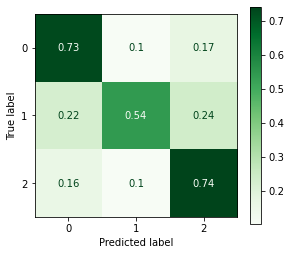

Training Score = 0.99
Test Score = 0.70


NameError: name 'joblib' is not defined

In [94]:
## logreg gridsearch
# clf = LogisticRegression(class_weight='balanced',solver='saga')
full_pipe.named_steps['clf'] = LogisticRegression(class_weight='balanced',penalty='l1',
                                      solver='sag')
params = {'clf__C':[1,3,5,10],
#           'clf__solver':['saga','sag'],
#           'text__vectorizer__stop_words':[None, stopwords_list],
          'text__vectorizer__tokenizer':[tokenizer.tokenize, lambda x: regexp_tokenize(x, pattern)]
         }

gridsearch = GridSearchCV(full_pipe,params,cv=3, scoring='f1_macro',
                          verbose=2, n_jobs=-1)

gridsearch.fit(X_train,y_train)
print(gridsearch.best_params_)

evaluate_classification(gridsearch.best_estimator_, X_test,y_test,
                        X_train = X_train,y_train=y_train)

# joblib.dump(gridsearch.best_estimator_,f"{save_path}gridsearch_log_reg.joblib")

## RandomForest

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:569: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

              precision    recall  f1-score   support

           0       0.67      0.61      0.64      1473
           1       0.48      0.57      0.52       756
           2       0.70      0.70      0.70      1771

    accuracy                           0.64      4000
   macro avg       0.62      0.63      0.62      4000
weighted avg       0.65      0.64      0.64      4000



/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curre

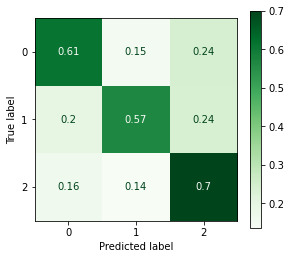

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Training Score = 1.00


/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Test Score = 0.64


NameError: name 'save_path' is not defined

In [103]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train_vec,y_train)

evaluate_classification(clf,X_test_vec,y_test,
                        X_train = X_train_vec, y_train=y_train)

joblib.dump(clf,f"{save_path}random_forest.joblib",compress=3)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

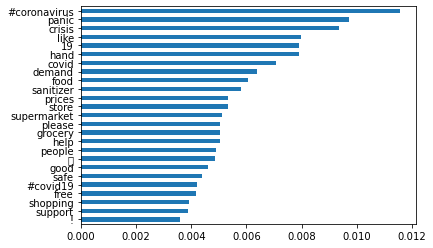

In [104]:
importantces = pd.Series(clf.feature_importances_, 
                         index=text_pipe.named_steps['vectorizer'].get_feature_names())
importantces.sort_values().tail(25).plot(kind='barh')

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

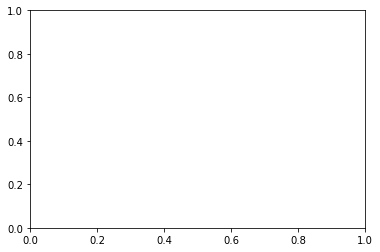

In [102]:
## Checking depths of rf trees
depths = [tree.get_depth() for tree in clf.estimators_]
sns.histplot(depths)

In [101]:
# ## rf gridsearch

# clf = RandomForestClassifier(class_weight='balanced')

# params = {'max_depth':[400,500,600]
#          }

# gridsearch = GridSearchCV(clf,params,cv=3, scoring='recall_macro',verbose=True, 
#                           n_jobs=-1)

# gridsearch.fit(X_train_vec,y_train)
# print(gridsearch.best_params_)
# evaluate_classification(gridsearch.best_estimator_, X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)
# joblib.dump(gridsearch.best_estimator_,f"{save_path}gridsearch_random_forest.joblib",compress=3)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# gridsearch.best_params_

In [ ]:
# pd.DataFrame(gridsearch.cv_results_).set_index('param_max_depth')['mean_test_score']

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
clf = MultinomialNB(fit_prior=False)#class_weight='balanced')
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)
joblib.dump(clf,f"{save_path}naive_bayes.joblib")

### LinearSVC

In [ ]:
# raise Exception('Check SVC parms before running!')

In [ ]:
clf = SVC(kernel='linear',class_weight='balanced',verbose=2)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)

In [ ]:
joblib.dump(clf,f"{save_path}svc_linear.joblib")

# iNTERPRET

## Testing Loading Models

In [98]:
import joblib

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
model = joblib.load(f"{save_path}random_forest.joblib")
model

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FileNotFoundError: [Errno 2] No such file or directory: './models/random_forest.joblib'

In [ ]:
text_pipe.named_steps['vectorizer'].get_feature_names()[:5]

In [ ]:
importantces = pd.Series(model.feature_importances_, 
                         index=text_pipe.named_steps['vectorizer'].get_feature_names())
importantces.sort_values().tail(25).plot(kind='barh')

# CONCLUSIONS & RECOMMENDATIONS

> Summarize your conclusions and bullet-point your list of recommendations, which are based on your modeling results.

## Combining Spacy and Scattertext

- https://towardsdatascience.com/setting-up-text-preprocessing-pipeline-using-scikit-learn-and-spacy-e09b9b76758f

In [ ]:
# # Visit https://spacy.io/usage for isntallation tool
# # !python -m spacy download en_core_web_sm
# import spacy
# nlp = spacy.load('en_core_web_sm')

In [ ]:
# nlp.pipeline

In [ ]:
# nlp.disable_pipes('tagger','ner')

In [ ]:
# nlp.pipeline

In [ ]:
#https://colab.research.google.com/github/DerwenAI/spaCy_tuTorial/blob/master/spaCy_tuTorial.ipynb#scrollTo=Bjz8pBV5D1r-
# !pip install scattertext

In [ ]:
# df

In [ ]:
# import scattertext as st
# st_corpus = st.CorpusFromPandas(df,
#                              category_col="SimpleSentiment",
#                              text_col="OriginalTweet",
#                              nlp=nlp).build()

In [ ]:
# df[]

In [ ]:
# st_html = st.produce_scattertext_explorer(
#     st_corpus,
#     category="Negative",
#     category_name="Negative Tweets",
#     not_category_name="Positive Tweets",
#     width_in_pixels=1000,
#     metadata=df[['Location','TweetAt']]#convention_df["speaker"]
# )

In [ ]:
# from IPython.display import IFrame
# file_name = "scattertext_negative.html"

# with open(file_name, "wb") as f:
#     f.write(st_html.encode("utf-8"))

# # IFrame(src=file_name, width = 1200, height=700)